In [2]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007f0b7701f5eb, Ptr{Nothing} @0x00007f0b76ff0204, P

# Simulation of sliding box

In [ ]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [ ]:
N = 25
Δt = 0.05
q0 = [0., 0., 0.]
v0 = [10., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt,relax_comp=true)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
# Direct

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

In [ ]:
j = 1
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [ ]:
sim_indirect[2][end]

# Trajectory optimization of sliding box

In [3]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [4]:
q1 = [0., 0., 0.]
qN = [4.85, 0., 0.]
N = 25
Δt = 0.05

q_min = [-10., -10., -10.]
q_max = [10., 10., 10.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - qN[1:2])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

get_prob_init (generic function with 1 method)

In [6]:
# Indirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)

@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
 57.667182 seconds (453.26 M allocations: 49.383 GiB, 21.43% gc time)


(Array{Float64,1}[[0.0, 0.0, 0.0], [0.492385, 2.82777e-6, 0.189935], [0.788272, 0.246791, 0.37987], [1.07394, 0.466225, 0.569806], [1.34961, 0.658762, 0.759741], [1.61554, 0.824854, 0.949676], [1.87194, 0.964945, 1.13961], [2.11904, 1.07947, 1.32955], [2.35707, 1.16886, 1.51948], [2.58622, 1.23354, 1.70942]  …  [3.78656, 1.12549, 2.84903], [3.95937, 1.02846, 3.03896], [4.12492, 0.909866, 3.2289], [4.28338, 0.770068, 3.41883], [4.43493, 0.609428, 3.60877], [4.57977, 0.428298, 3.7987], [4.71807, 0.227027, 3.98864], [4.85, 0.00595689, 4.17858], [4.85, 1.19813e-16, 4.36851], [4.85, 0.0, 4.55845]], Array{Float64,1}[[10.4272, 0.0, 3.7987], [9.67092, -1.85883, 3.7987], [7.32734, 2.39111, 3.7987], [7.18086, 0.614734, 3.7987], [6.65383, -1.00463, 3.7987], [5.80214, -2.39261, 3.7987], [4.69503, -3.49046, 3.7987], [3.41118, -4.25717, 3.7987], [2.03459, -4.67077, 3.7987], [0.650264, -4.7287, 3.7987]  …  [-3.90947, 0.403539, 3.7987], [-3.66169, 1.59105, 3.7987], [-3.11399, 2.67685, 3.7987], [-2.299

In [7]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  508.78 MiB
  allocs estimate:  2736260
  --------------
  minimum time:     391.375 ms (0.00% GC)
  median time:      395.461 ms (0.00% GC)
  mean time:        404.928 ms (0.00% GC)
  maximum time:     474.809 ms (0.00% GC)
  --------------
  samples:          13
  evals/sample:     1

In [9]:
# Semidirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
  7.423298 seconds (21.62 M allocations: 3.077 GiB, 67.14% gc time)


(Array{Float64,1}[[0.0, 0.0, 0.0], [0.471132, 1.30634e-13, 0.0242277], [0.91818, 0.0, 0.0484554], [1.34115, 4.55494e-14, 0.0726831], [1.74012, -7.14459e-5, 0.0969108], [2.11488, 0.0, 0.121138], [2.46565, 0.0, 0.145366], [2.79233, 0.0, 0.169594], [3.0949, 0.0, 0.193822], [3.37329, 0.0, 0.218049]  …  [4.5393, 0.0, 0.363415], [4.64965, 0.0, 0.387643], [4.73602, 0.0, 0.411871], [4.79842, 0.0, 0.436099], [4.83686, 1.73472e-18, 0.460326], [4.85134, -6.09802e-15, 0.484554], [4.85125, -1.90016e-13, 0.508782], [4.85087, 3.77939e-10, 0.533009], [4.85034, -6.4263e-5, 0.557237], [4.85, 0.0, 0.581465]], Array{Float64,1}[[9.90445, 0.0, 0.484554], [9.41987, -0.228266, 0.484554], [8.93047, -0.433068, 0.484554], [8.43709, -0.614316, 0.484554], [7.94178, -0.773498, 0.484554], [7.44055, -0.904332, 0.484554], [6.94128, -1.01619, 0.484554], [6.4399, -1.10276, 0.484554], [5.93805, -1.16555, 0.484554], [5.43594, -1.20445, 0.484554]  …  [2.5112, -0.955029, 0.484554], [2.04323, -0.834256, 0.484554], [1.58297, 

In [10]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  155.70 MiB
  allocs estimate:  825543
  --------------
  minimum time:     81.352 ms (0.00% GC)
  median time:      117.116 ms (0.00% GC)
  mean time:        111.032 ms (0.00% GC)
  maximum time:     147.018 ms (0.00% GC)
  --------------
  samples:          46
  evals/sample:     1

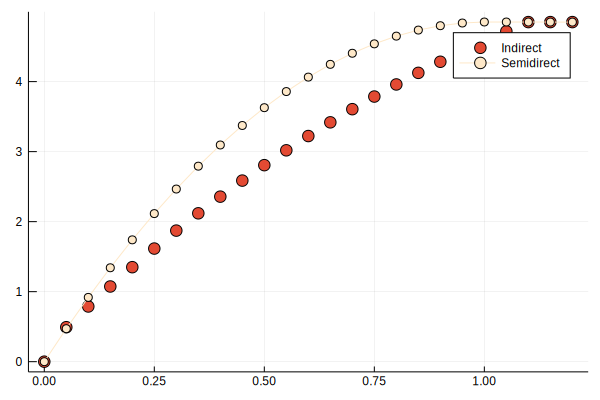

In [11]:
j = 1
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [12]:
display(traj_indirect[2][1])
display(traj_semidirect[2][1])

3-element Array{Float64,1}:
 10.427240184188815 
  0.0               
  3.7987046502198107

3-element Array{Float64,1}:
 9.90444502225334   
 0.0                
 0.48455390427920564

# Trajectory optimization of little dog

In [13]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 10.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [15]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:8700'


Could not open browser automatically: ErrorException("failed process: Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(3)) [3]")
Please open the following URL in your browser:
http://127.0.0.1:8700


In [16]:
N = 8
Δt = 0.025
q0 = [0., -.275, 0., 0., 0., 0., 0., pi/4, pi/4, -pi/4, -pi/4, -pi/2, -pi/2, pi/2, pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [17]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -.2*pi, 0., 0., 0., 0., -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.1, .2*pi, 0., 0., 0., 0., 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

x_goal = 0.1

N = 15
Δt = 0.05

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1) - q_nom)
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
    add_eq!(sim_data, :cqNlegs, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))

    for n = 1:N
        add_eq!(sim_data, Symbol("cq1", n), 2, x -> vs(x, Symbol("q", n))[8:9] + vs(x, Symbol("q", n))[11:-1:10])
        add_eq!(sim_data, Symbol("cq2", n), 2, x -> vs(x, Symbol("q", n))[12:13] + vs(x, Symbol("q", n))[15:-1:14])
    end
end

function add_prob_obj!(sim_data)
    for n = 1:N-1
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_limit = 10.
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - q_nom[1]) + q_nom[1]
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];

In [18]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [ ]:
# Multi-steps

reps = 5

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)